In [1]:
import sys
import gzip
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm import tqdm
from torchvision import transforms
from multiprocessing import cpu_count
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

sys.path.append('../')

from src.deepfashion.dataset import DeepFashionDataset
from src.fashionnet.model import FashionNet, PredictionHead

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: ' + str(device))

Device: cuda:0


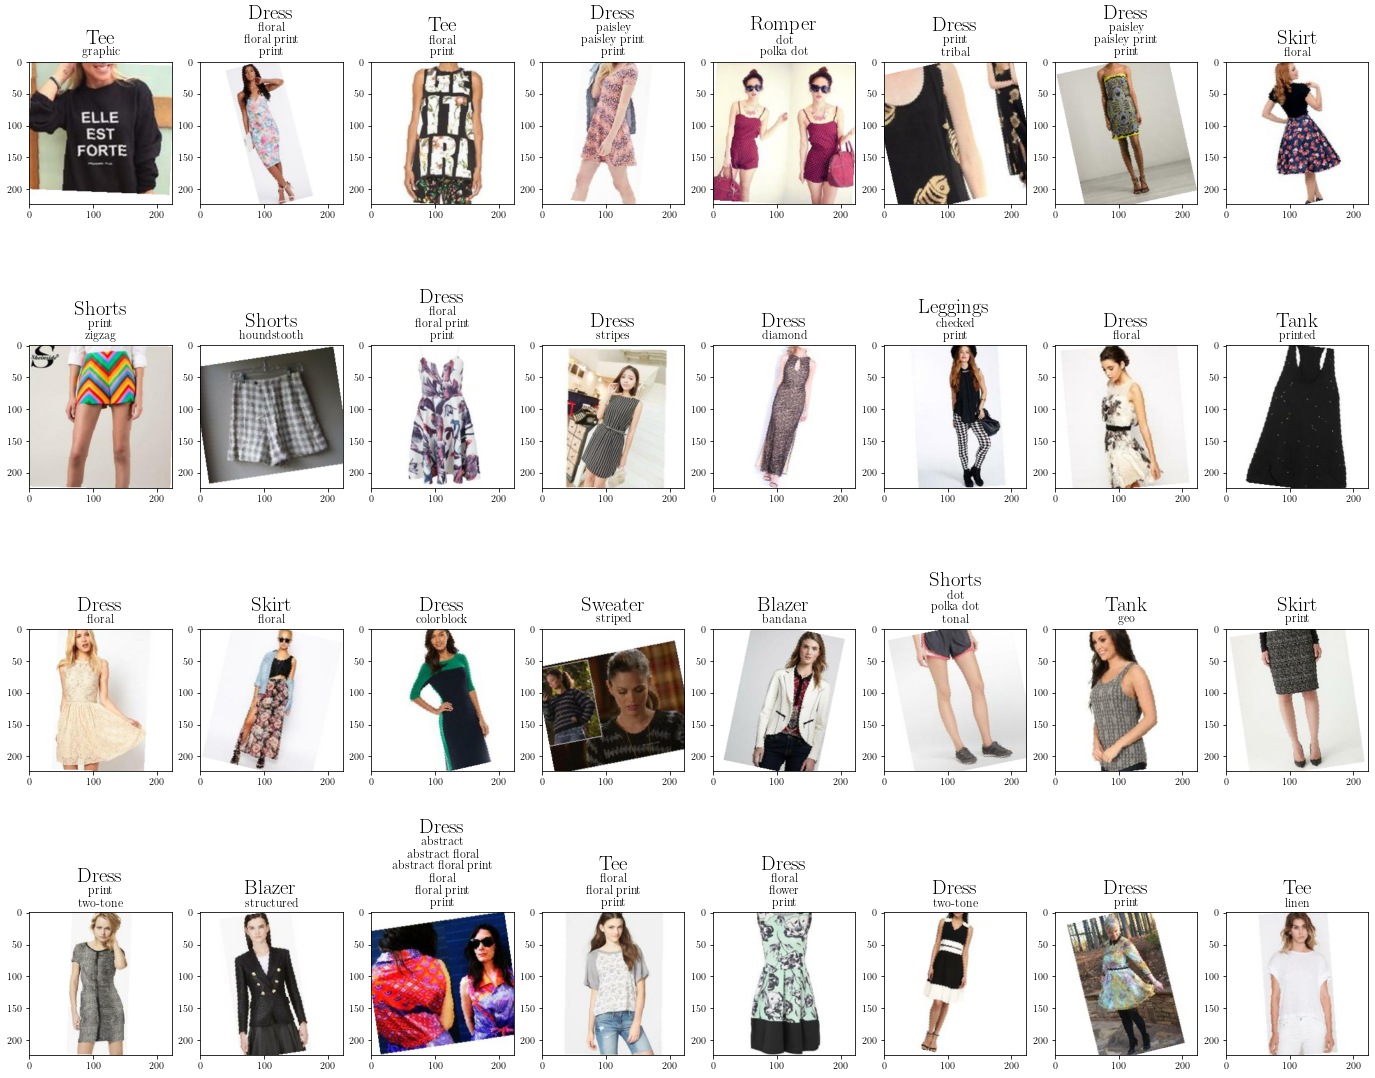

In [2]:
preprocessing = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.75,1.25), ratio=(1,1)),
    transforms.RandomRotation(15, fill=255),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

fashion_dataset = DeepFashionDataset(root_dir='../data/DeepFashion/', img_transforms=preprocessing)

train_size = int(0.8 * len(fashion_dataset))
test_size = len(fashion_dataset) - train_size

train_set, test_set = torch.utils.data.random_split(fashion_dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=cpu_count())
test_loader = DataLoader(test_set, batch_size=32, shuffle=True, num_workers=cpu_count())

for batch in train_loader:
    fashion_dataset.plot_image_batch(batch)
    break

## Evaluate model results

In [8]:
model_name = 'normal-24-epochs'
fashion_net = FashionNet(device, fashion_dataset.num_categories, fashion_dataset.num_textures)
fashion_net.load('../results/models/' + model_name + '.pt')

In [9]:
target_id = fashion_dataset.category_labels.index.get_loc('img_resized/Striped_Textured_Sweater/img_00000024.jpg')
attack_id = fashion_dataset.category_labels.index.get_loc('img_resized/Linen-Blend_Drawstring_Shorts/img_00000026.jpg')

class FixedSampler(torch.utils.data.Sampler):
    def __iter__(self):
        return iter([target_id, attack_id])
    def __len__(self):
        return 2

eval_set = DeepFashionDataset(root_dir='../data/DeepFashion/')
eval_loader = DataLoader(eval_set, batch_size=16, sampler=FixedSampler(None),  num_workers=4)
eval_set.split

<Split.BOTH: 'both'>

[tensor(0.0031), tensor(0.0054), tensor(0.0059), tensor(0.0163), tensor(0.0169), tensor(0.0173), tensor(0.0371), tensor(0.1207), tensor(0.2472), tensor(0.5157)]
['Dress', 'Tank', 'Shorts', 'Henley', 'Cardigan', 'Hoodie', 'Blouse', 'Top', 'Sweater', 'Tee']
[tensor(0.0112), tensor(0.0113), tensor(0.0180), tensor(0.0208), tensor(0.0211), tensor(0.0219), tensor(0.0250), tensor(0.0453), tensor(0.1997), tensor(0.4596)]
['nautical stripe', 'print', 'stripes', 'nautical', 'marled', 'nautical striped', 'breton stripe', 'breton', 'stripe', 'striped']


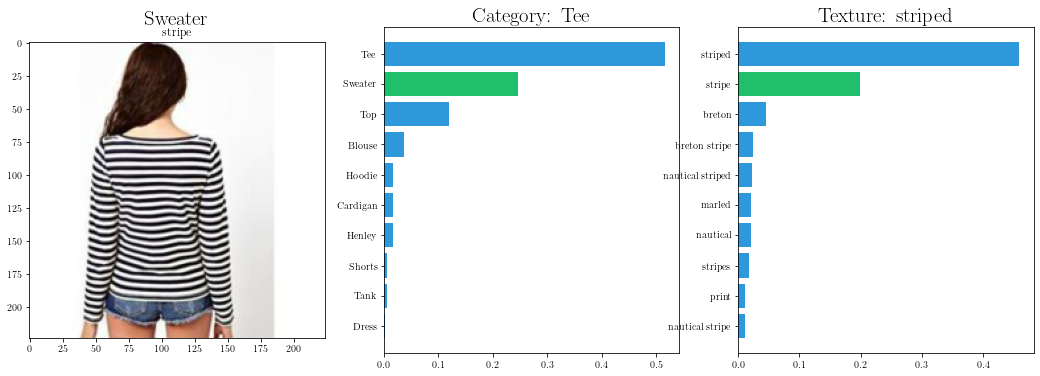

[tensor(1.8125e-06), tensor(2.8439e-06), tensor(1.1450e-05), tensor(2.1354e-05), tensor(2.3611e-05), tensor(8.1404e-05), tensor(0.0002), tensor(0.0003), tensor(0.0222), tensor(0.9772)]
['Blouse', 'Joggers', 'Top', 'Leggings', 'Culottes', 'Sweatshorts', 'Cutoffs', 'Skirt', 'Trunks', 'Shorts']
[tensor(0.0214), tensor(0.0237), tensor(0.0342), tensor(0.0507), tensor(0.0668), tensor(0.0741), tensor(0.0823), tensor(0.0834), tensor(0.0878), tensor(0.2200)]
['floral print', 'pom-pom', 'tribal', 'stripe', 'printed', 'polka dot', 'dot', 'floral', 'striped', 'print']


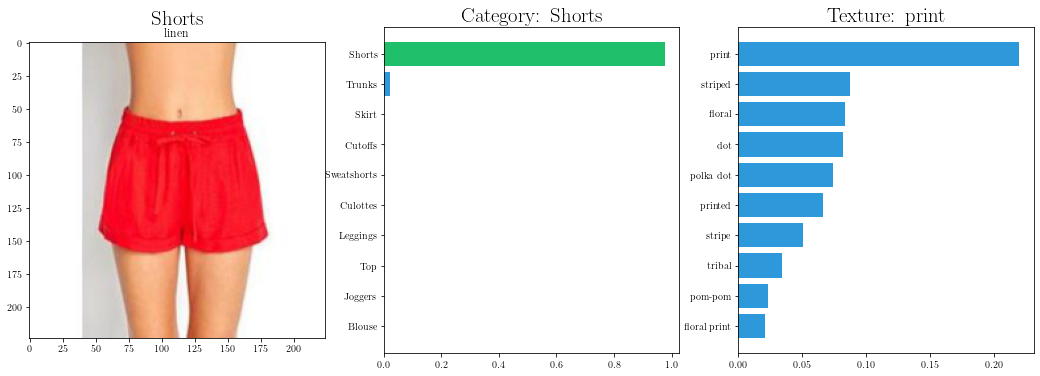

In [10]:
for batch in eval_loader:
    eval_set.visualize_predictions(fashion_net, batch)
    break

# Remove classifier head and generate embeddings

In [11]:
fashion_net.model.eval()
fashion_net.model.classifier = nn.Sequential()

In [12]:
batch_size = 48
eval_loader = DataLoader(eval_set, batch_size=batch_size, shuffle=False, num_workers=4)

with gzip.open('../data/DeepFashion/vectors/' + model_name + '.tsv.gz', 'wt') as f:
    f.write('image\t' + '\t'.join(map(lambda x: 'd' + str(x), range(1280))) + '\n')
    for batch in tqdm(eval_loader):
        vectors = fashion_net.model(batch['image'].to(device)).detach().cpu().numpy()
        for example_idx in range(batch['image'].shape[0]):
            f.write(batch['name'][example_idx] + '\t' + '\t'.join(map(str, vectors[example_idx])) + '\n')

100%|██████████| 2222/2222 [08:15<00:00,  4.49it/s]
